# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms.  



### Part 0: Explore BlackjackEnv

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

#### Rules of the Game

Blackjack The object of the popular casino card game of blackjack is to
obtain cards the sum of whose numerical values is as great as possible without exceeding 21. All face cards count as 10, and an ace can count either as 1 or as 11. We consider
the version in which each player competes independently against the dealer. The game
begins with two cards dealt to both dealer and player. One of the dealer’s cards is face
up and the other is face down. If the player has 21 immediately (an ace and a 10-card),
it is called a natural. He then wins unless the dealer also has a natural, in which case the
game is a draw. If the player does not have a natural, then he can request additional
cards, one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust). If he goes
bust, he loses; if he sticks, then it becomes the dealer’s turn. The dealer hits or sticks
according to a fixed strategy without choice: he sticks on any sum of 17 or greater, and
hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome—win,
lose, or draw—is determined by whose final sum is closer to 21.


Playing blackjack is naturally formulated as an episodic finite MDP. Each game of
blackjack is an episode. Rewards of +1, 1, and 0 are given for winning, losing, and
drawing, respectively. All rewards within a game are zero, and we do not discount ( = 1);
therefore these terminal rewards are also the returns. The player’s actions are to hit or
to stick. The states depend on the player’s cards and the dealer’s showing card. We
assume that cards are dealt from an infinite deck (i.e., with replacement) so that there is
no advantage to keeping track of the cards already dealt. If the player holds an ace that
he could count as 11 without going bust, then the ace is said to be usable. In this case
it is always counted as 11 because counting it as 1 would make the sum 11 or less, in
which case there is no decision to be made because, obviously, the player should always
hit. Thus, the player makes decisions on the basis of three variables: his current sum
(12–21), the dealer’s one showing card (ace–10), and whether or not he holds a usable
ace. This makes for a total of 200 states.

   
Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits. To
find the state-value function for this policy by a Monte Carlo approach, one simulates
many blackjack games using the policy and averages the returns following each state.
In this way, we obtained the estimates of the state-value function shown in Figure 5.1.
The estimates for states with a usable ace are less certain and less regular because these
states are less common. In any event, after 500,000 games the value function is very well
approximated.

In [1]:
import gym
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [2]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [3]:
for i_episode in range(3):
    state = env.reset()
    while True:
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print("players hand: {0}".format(state[0]))
            print("Dealers' open card: {0}".format(state[1]))
            print("usable ace? :{0}".format(state[2]))
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

players hand: 20
Dealers' open card: 5
usable ace? :False
End game! Reward:  1.0
You won :)

players hand: 15
Dealers' open card: 7
usable ace? :False
End game! Reward:  -1.0
You lost :(

players hand: 30
Dealers' open card: 7
usable ace? :False
End game! Reward:  -1
You lost :(



### Part 1: MC Prediction: State Values

In this section, you will write your own implementation of MC prediction (for estimating the state-value function).

We will begin by investigating a policy where the player always sticks if the sum of her cards exceeds 18.  The function `generate_episode_from_limit` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [4]:
def generate_episode_from_limit(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit` function.*) 

Note - If the player is bust, then state doesnt get updated. You can see that in example 1 and 2 of generate episode from limit. 

In [5]:
for i in range(3):
    print(generate_episode_from_limit(env))

[((15, 10, True), 1, 0), ((12, 10, False), 1, -1)]
[((12, 10, False), 1, -1)]
[((5, 10, False), 1, 0), ((7, 10, False), 1, 0), ((16, 10, False), 1, -1)]


In [6]:
episode = generate_episode_from_limit(env)
states, actions, rewards = zip(*episode)
print(states, actions, rewards)

((20, 9, False),) (0,) (1.0,)


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated value of state `s`.  For example, if your code returns the following output:
```
{(4, 7, False): -0.38775510204081631, (18, 6, False): -0.58434296365330851, (13, 2, False): -0.43409090909090908, (6, 7, False): -0.3783783783783784, ...
```
then the value of state `(4, 7, False)` was estimated to be `-0.38775510204081631`.

If you are unfamiliar with how to use `defaultdict` in Python, you are encouraged to check out [this source](https://www.accelebrate.com/blog/using-defaultdict-python/).

![Monte Carlo First Visit State Value prediction Algo](mc-pred-state.png)

In [7]:
from collections import defaultdict
import numpy as np
import sys

# the black jack game by default is designed to handle first visit
# monte carlo prediction. I.E same state won't happen in the episode more than once
# i.e you cannot have (player hand sum, Dealers one card out, Usable Ace) tuple to repeat
# unless the action is stick, by then the reward is provided and the state is not recorded.
def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionary of lists
    returns = defaultdict(int)
    N = defaultdict(int)
     
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # generate an episode
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)
        # discounting formula
        # discount the next state lesser than its next state.
        # why we create an extra element in discounting, because for the last before state
        # we need to discount the next/final state
        discounting = np.array([gamma ** i for i in range(len(rewards)+1)])
        for index, state in enumerate(states):
            returns[state] += sum(rewards[index:] * discounting[:-(index+1)])
            # N(s) is the number of occurence of state s which has occured for the list of episodes.
            # rewards_list length is N(s)'s value.
            N[state]+=1
        
    
    V = {state:reward_sum/N[state] for state, reward_sum in returns.items()}
            
        
    return V

Use the cell below to calculate and plot the state-value function estimate.  (_The code for plotting the value function has been borrowed from [this source](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py) and slightly adapted._)

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

In [8]:
from plot_utils import plot_blackjack_values

# obtain the value function
V = mc_prediction_v(env, 500000, generate_episode_from_limit)

# plot the value function
plot_blackjack_values(V)

Episode 500000/500000.

There are close to 200 states, the first diagram show states with a usable ace. The second diagram show the statews without an usable ace. We can understand from the diagrams that, the state value functions of the player's hand is higher as their sum is 18 and above for sure in both cases. With usable Ace, We have decent chances of winning since the beginning of that episode. So the states with usable ace are positioned with higher state values than those without the ace, generally. Also, there is a drop in state values, when the dealers open card is more than 8.

### Part 2: MC Prediction: Action Values

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [9]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

![Monte Carlo First Visit Action Value prediction Algo](mc-pred-action.png)

In [10]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    # count the occurence of each state, action pair
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    # Q is the actions value function which returns_sum's action value / # of occurenece of each action for a given state
    # for a set of episodes.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)
        
        discounting  = np.array([ gamma ** i for i in range(len(rewards)+1)])
        
        for index, state in enumerate(states):
            returns_sum[state][actions[index]] += sum(rewards[index:] * discounting[:-(index+1)])
            N[state][actions[index]] += 1
            Q[state][actions[index]] = returns_sum[state][actions[index]]/ N[state][actions[index]]
    
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

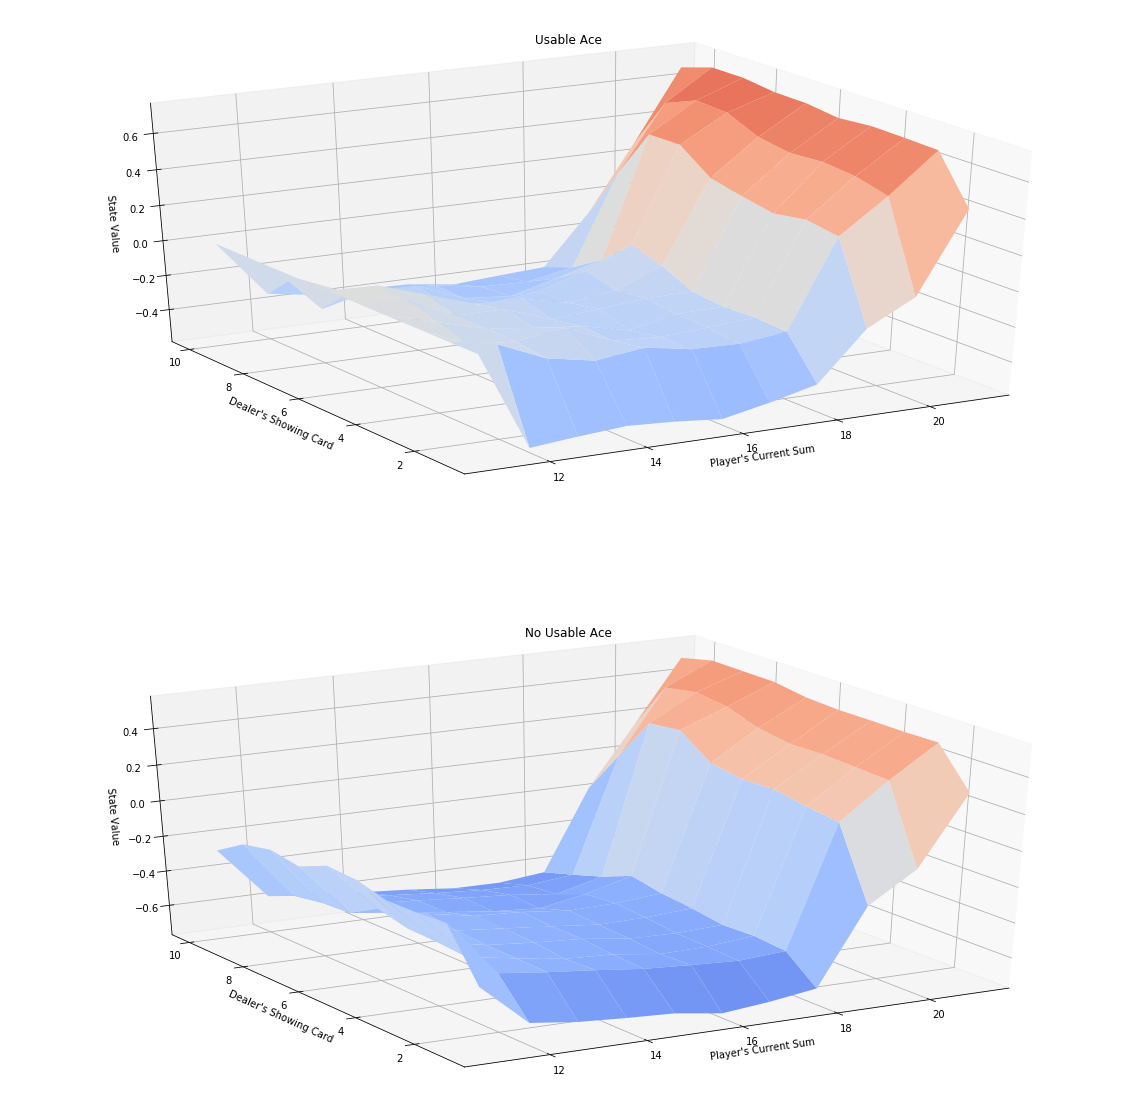

In [11]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the state-value function

V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 3: MC Control: GLIE

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

![Monte Carlo Control - Greedy in limit with exploration Algo](mc-control-glie.png)

###### Algorithm we follow for greedy policy

![Greedy Policy](greedy_policy.png)

In [12]:
"""
  In blackjack game we create policy for each and every episode. Its the same for the whole episode.
  Based on the card we get(Q_current_state), we will decide if we want to hit or stick.
  These are the two actions we take to traverse from any state to another.
  
  We also decide the action based on our previous interactions with the environment.
  Q_current_state has action values which is a history of our previous interaction with the env
  So according to Greedy in Limit with infinite exploration,
  
  we select a policy with highest action value function to have more episilon than the others
  
"""
def get_policy(epsilon, Q_current_state, nA):
    greedy_action_index = np.argmax(Q_current_state)
    # lets first put an equiprobable policy on all states.
    current_policy = (epsilon/nA) * np.ones(nA)
    # introducing greediness to the highest action value
    current_policy[greedy_action_index] = 1-epsilon + current_policy[greedy_action_index]
    
    return current_policy
    

In [13]:
"""
  To generate an episode we need three parameters,
  the environment,
  the updated epsilon, 
  the action value (experience)
  we have accumulated so far. This is very helpful to check if the random state 
  ( the player hand in a black jack game, dealers's open card, whether player has an usable ace or not) is already been 
  experienced by the reinforced learner.
  the number of actions a player can take = 2 in card game [0,1] 0 to stick and 1 to hit.
  
  it returns an episode.

"""
def generate_episode_for_GLIE(env, epsilon, Q_so_far,nA):
    episode = []
    state =  env.reset()
    
    # start the game
    while True:
        # if reinforced learner has already seen this hand
        if state in Q_so_far:
            action = np.random.choice(np.arange(nA), p=get_policy(epsilon, Q_so_far[state], nA))
        # else choose a random action for this hand.
        else:
            action = env.action_space.sample()
        
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [14]:
def calculate_action_value_function(episode, Q, N, gamma, alpha=None):
    states, actions, rewards = zip(*episode)
    discounting = np.array([gamma**i for i in range(len(rewards)+1)])
    
    for index, state in enumerate(states):
        old_N = N[state][actions[index]]
        old_Q = Q[state][actions[index]]
        
        # update the count for state action pair
        N[state][actions[index]] = old_N + 1
        # get the current discounted reward
        current_reward =  sum(rewards[index:] * discounting[:-(index+1)])
        # update action value for the state and the action taken
        if alpha:
            Q[state][actions[index]] = old_Q + alpha * (current_reward -old_Q)
        else:
            Q[state][actions[index]] = old_Q + ((current_reward -old_Q)/N[state][actions[index]])
    
    return Q,N
        
        

In [15]:
def mc_control_GLIE(env, num_episodes, gamma=1.0):
    # number of actions we can take in any state.
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set epison value for this episode
        epsilon = 1.0/((i_episode/8000)+1)
        
        # create a policy for the episode
        # generate the episode with policy pi
        episode = generate_episode_for_GLIE(env, epsilon, Q, nA)
        #Calclate Action value function
        Q,N = calculate_action_value_function(episode, Q, N, gamma)
    
    # by now we would have got experience on what action to take if we start with 
    # a state (player_hand, dealer's open card, usable_ace?)
    
    # pick the optimal policy now ( that is to stick or to hit for a given state)
    
    policy = {state: np.argmax(actions) for state, actions in Q.items()}    
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [16]:
# obtain the estimated optimal policy and action-value function
policy_glie, Q_glie = mc_control_GLIE(env, 500000)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

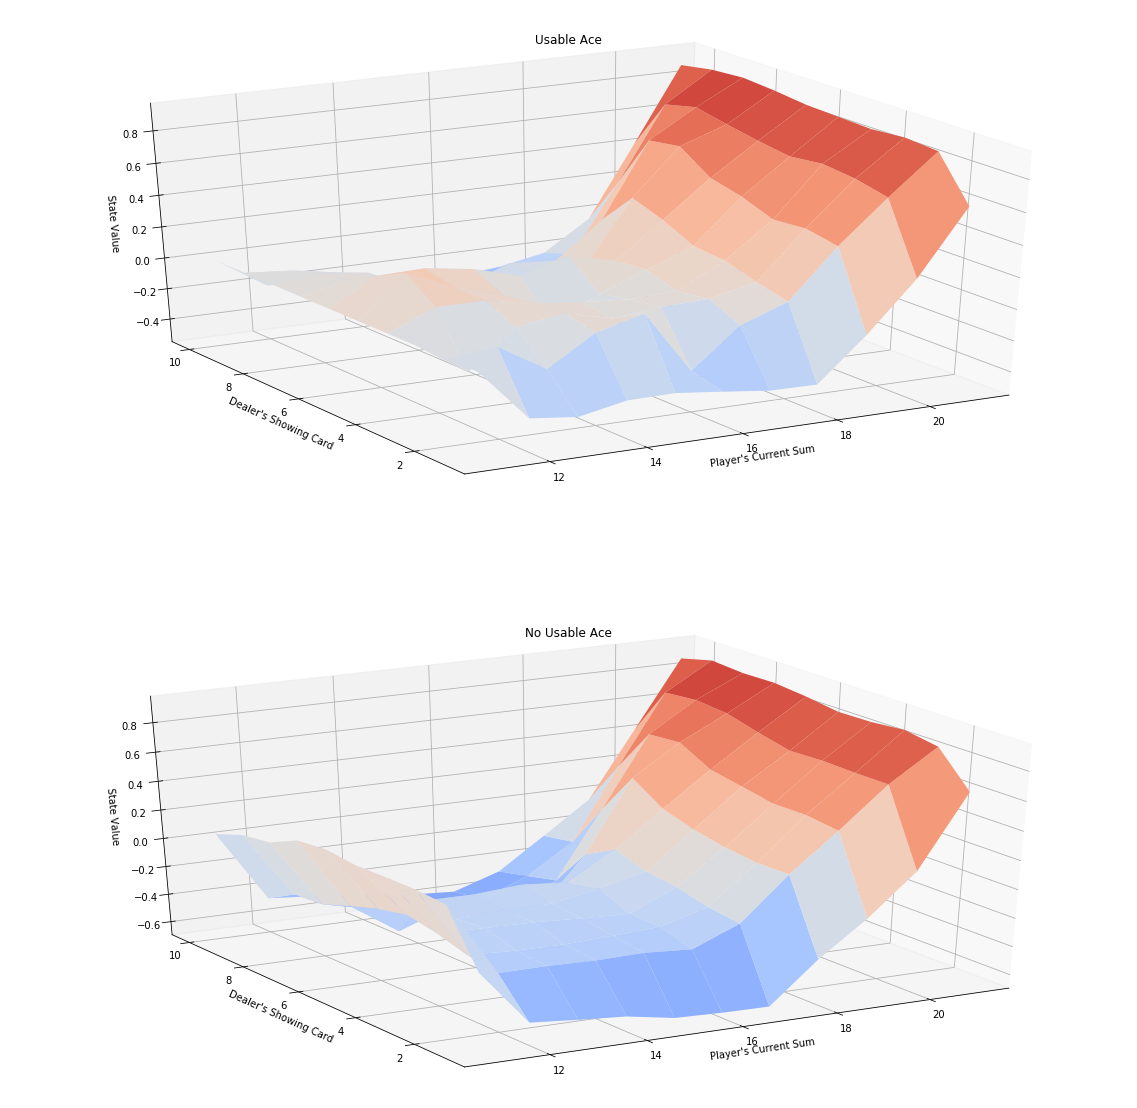

In [17]:
# obtain the state-value function
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

# plot the state-value function
plot_blackjack_values(V_glie)

Finally, we visualize the policy that is estimated to be optimal.

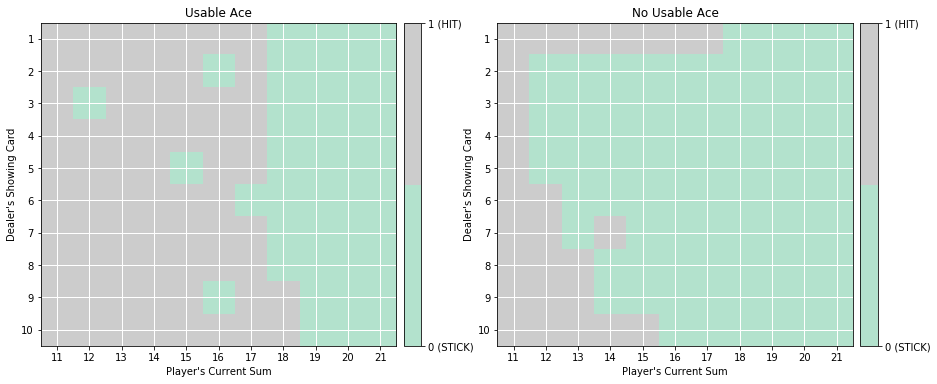

In [18]:
from plot_utils import plot_policy

# plot the policy
plot_policy(policy_glie)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$ and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)

### Part 4: MC Control: Constant-$\alpha$

So far we have done action value update using a running average calculation algorithm. But it has a caveat. Lets say a state appears the first time in the learning process, its current discounted return minus the current action value function output  is given more weightage than the same state appearing 1000th time ( we get the proportion of 1000th state appearance output value which is  1/1000 times). So to make sure we always weigh the appearances of state the same way, we multiply a constant step-size parameter $\alpha$.  $\alpha$ must be between 0 and 1. Higher values of $\alpha$ will result in faster learning, but values of $\alpha$ that are too high can prevent MC control from converging to $\pi_*$ 
Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

![Monte Carlo Control with constant alpha](mc-control-constant-a.png)

In [19]:
def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set epison value for this episode
        epsilon = 1.0/((i_episode/8000)+1)
        
        # create a policy for the episode
        # generate the episode with policy pi
        episode = generate_episode_for_GLIE(env, epsilon, Q, nA)
        #Calclate Action value function
        Q,N = calculate_action_value_function(episode, Q, N, gamma, alpha)
    
    # by now we would have got experience on what action to take if we start with 
    # a state (player_hand, dealer's open card, usable_ace?)
    
    # pick the optimal policy now ( that is to stick or to hit for a given state)
    
    policy = {state: np.argmax(actions) for state, actions in Q.items()}    
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [20]:
# obtain the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 500000, 0.008)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

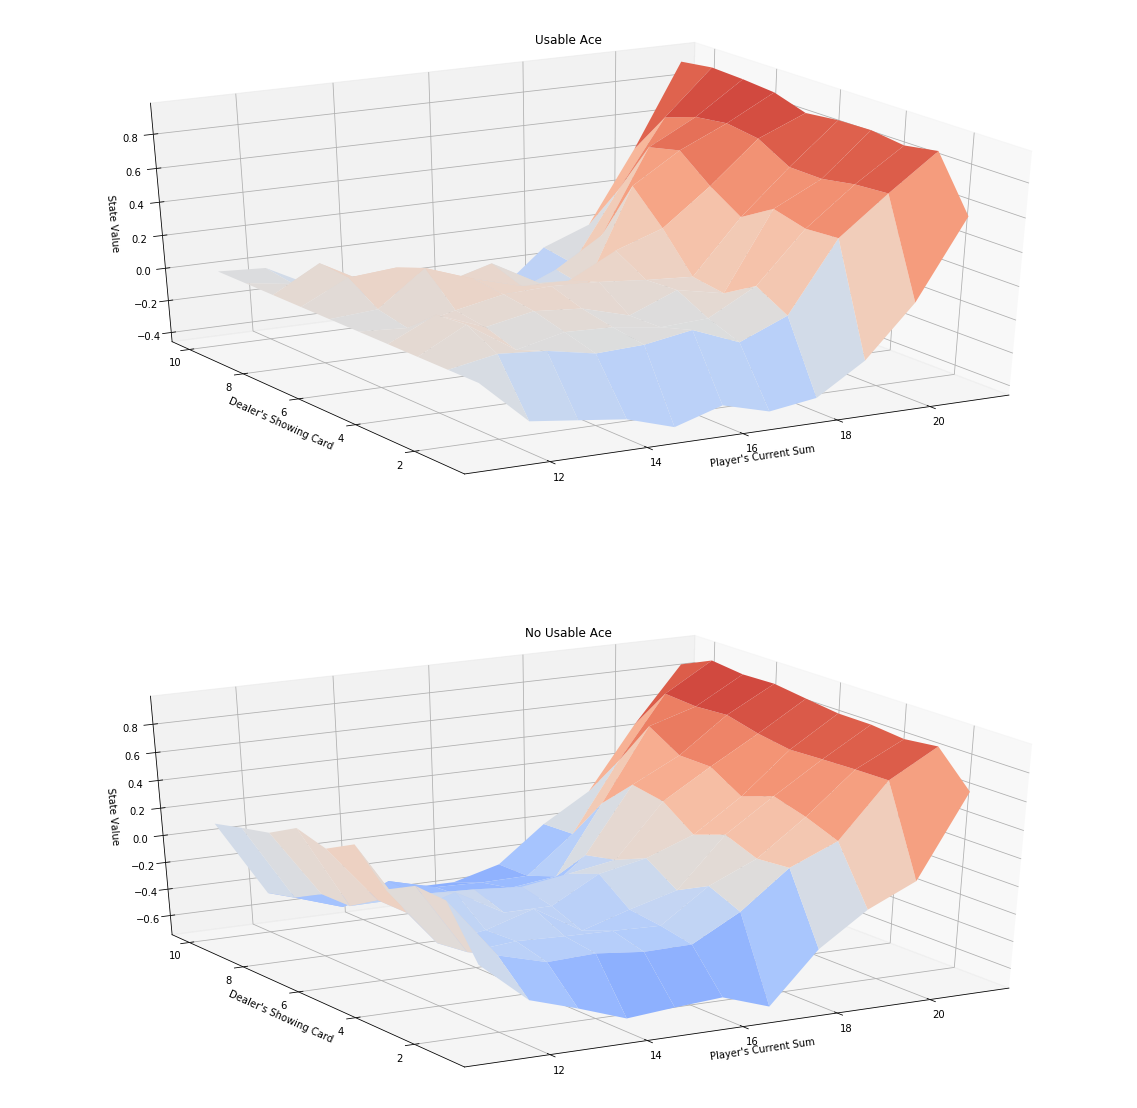

In [21]:
# obtain the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

# plot the state-value function
plot_blackjack_values(V_alpha)

Finally, we visualize the policy that is estimated to be optimal.

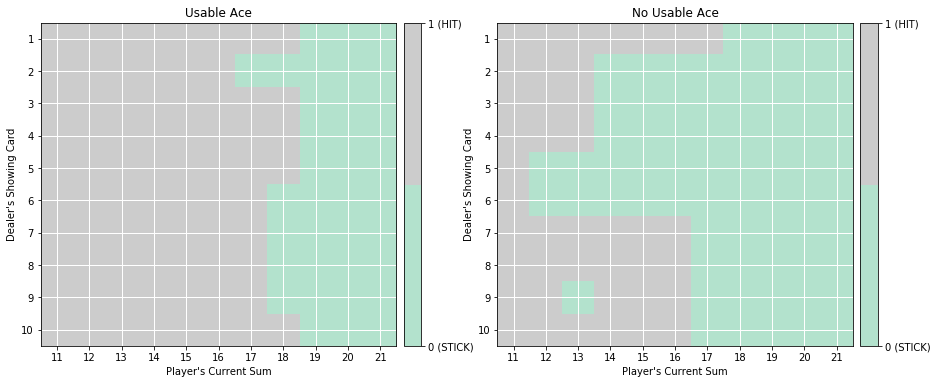

In [22]:
# plot the policy
plot_policy(policy_alpha)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)

#### Playing games with the dealer with  $\pi_*$ 
  I have added the last state of the game when it ends which contains (sum(player_hand), sum(dealer_hand), usable_ace)

In [37]:
def generate_optimal_policy_episode(bj_env, policy):
    episode = []
    state = bj_env.reset()
    while True:
        if state in policy:
            action = np.argmax(policy[state])
        else:
            print(" the following state not seen in the policy {0}".formate(state))
            action = bj_env.action_space.sample()
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            episode.append((state[0], sum(bj_env.dealer), state[2]))
            break
    return episode

In [44]:
for i in range(3):
    episode = generate_optimal_policy_episode(env, policy_alpha)
    if episode[-2][-1] == 1:
        print("player has won the game and here are the results")
    elif episode[-2][-1] == 0:
        print("Its a tie game and here are the results")
    else:
        print("player has lost the game and here are the results")
    print(episode)
    print()

player has lost the game and here are the results
[((11, 2, False), 0, -1.0), (11, 18, False)]

player has lost the game and here are the results
[((15, 10, False), 0, -1.0), (15, 20, False)]

player has lost the game and here are the results
[((13, 3, False), 0, -1.0), (13, 21, False)]

